In [62]:
import numpy as np
from neural_net.neuralnet import NeuralNet
import neural_net.activation_functions as af
from matplotlib import pyplot as plt
import itertools
import json
import csv
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6 # resize figures
plt.style.use('bmh')

Preprocessign dat

In [63]:
with open('resources/cruzeirodosul2010daily.csv', 'r') as f:
    reader = csv.DictReader(f, delimiter=';')
    avg_temps = np.array([l['AvgTemp'] for l in reader])
    avg_temps = np.array([np.nan if l=='' else l for l in avg_temp], dtype='float64') # replace missing values with NaN
with open('resources/cruzeirodosul2010daily.csv', 'r') as f:
    reader = csv.DictReader(f, delimiter=';')
    dates = np.array([l['Date'] for l in reader], dtype='int64')
dates[0:5], avg_temps[0:5]

(array([40179, 40180, 40181, 40182, 40183]),
 array([27.14, 27.7 , 28.68, 26.4 , 24.98]))

Grafické znázornění časové řady

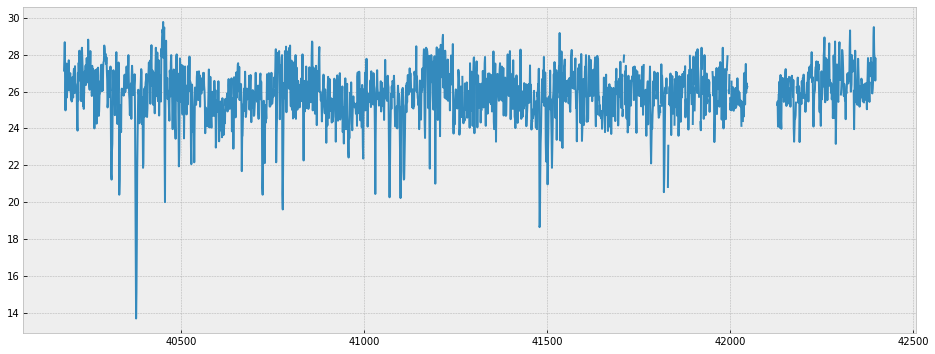

In [64]:
plt.plot(dates, avg_temps)

## Doplnění chybějících hodnot

Ověření předpokladu, že se jedná o časovou řadu

In [65]:
np.all(np.diff(dates) > 0)

True

In [70]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [73]:
nans, x = nan_helper(avg_temps)
avg_temps[nans]= np.interp(x(nans), x(~nans), avg_temps[~nans])

array([27.74, 25.54, 26.48, 27.68, 27.34, 27.64, 28.62, 26.32, 26.62,
       26.46, 26.48, 25.94, 26.42, 25.58, 25.88, 26.34, 24.56, 25.44,
       27.96, 27.18, 24.56, 27.12, 28.72, 25.72, 23.16, 24.56, 26.32,
       27.46, 27.04, 26.62, 25.5 , 25.44, 26.84, 28.36, 28.68, 26.94,
       26.64, 26.24, 25.84, 26.14, 26.6 , 28.26, 28.24, 27.92, 27.28,
       26.04, 25.76, 26.42, 26.26, 25.52, 25.74, 24.5 , 26.06, 25.9 ,
       26.2 , 26.78, 26.98, 26.68, 26.44, 27.02, 26.6 , 26.72, 28.44,
       29.32, 27.28, 26.  , 26.1 , 26.38, 27.98, 27.64, 27.08, 27.68,
       26.86, 26.04, 23.96, 25.38, 27.26, 28.22, 27.12, 26.2 , 26.44,
       25.38, 25.76, 25.28, 26.66, 27.78, 26.98, 26.38, 26.04, 25.18,
       25.9 , 25.64, 26.3 , 25.96, 26.7 , 26.58, 26.24, 25.64, 25.46,
       25.6 , 25.51, 25.42, 26.4 , 25.62, 25.56, 26.  , 26.44, 25.78,
       25.94, 25.04, 26.28, 26.84, 27.82, 27.3 , 27.56, 25.9 , 25.44,
       26.48, 26.66, 26.84, 27.82, 27.69, 27.56, 25.92, 25.9 , 26.16,
       26.62, 28.94,

grafický výsledek interpolace

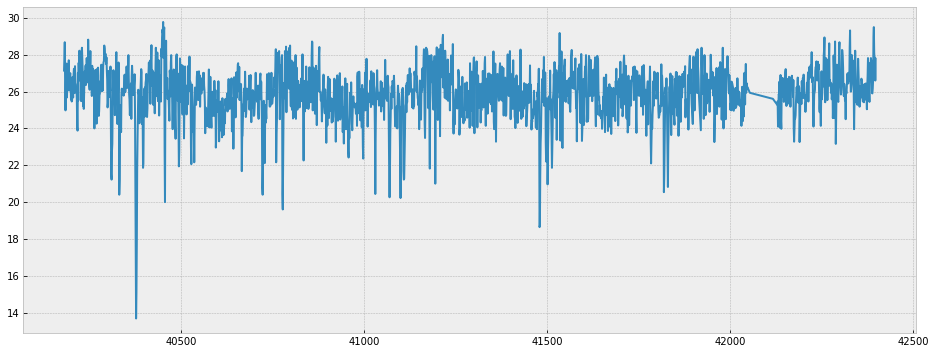

In [76]:
plt.plot(dates, avg_temps)